SN7

In [ ]:
import os
import numpy as np
import rasterio
import torch
import cv2
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from glob import glob
import geopandas as gpd
from rasterio.features import rasterize
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.transforms.functional as TF
import random
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from torch.optim.lr_scheduler import ReduceLROnPlateau
import albumentations as A
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset
import seaborn as sns

Funzione per calcolare media e deviazione standard

In [ ]:
def compute_mean_std(image_paths):
    means = []
    stds = []

    for img_path in image_paths:
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)  # Carica l'immagine inclusi tutti i canali
        #img_rgb = img[:, :, :3]  # Prendo i primi tre canali (RGB)
        #permute mi serve perchè img la leggo con opencv che mi da HxWxC e pytorch vuole CxHxW
        img_tensor = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)  # Converti in tensor e permuta le dimensioni a (Canali, Altezza, Larghezza)

        means.append(img_tensor.mean(dim=(1, 2)))  # Calcola e aggiungi la media per ogni canale (RGB) alla lista delle medie (1=h, 2=w)
        stds.append(img_tensor.std(dim=(1, 2)))    # Calcola e aggiungi la deviazione standard per ogni canale (RGB) alla lista delle deviazioni standard

    mean = torch.stack(means).mean(dim=0)  # Combina tutte le medie delle immagini e calcola la media finale per ogni canale
    std = torch.stack(stds).mean(dim=0)    # Combina tutte le deviazioni standard delle immagini e calcola la deviazione standard finale per ogni canale

    return mean.tolist(), std.tolist()  # Converte i tensori risultanti in liste e li restituisce

In [ ]:
# Path alle immagini nella cartella "training/images"
image_paths = glob('training/images_masked/*.tif')

# Esegui la computazione su GPU se disponibile
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

mean, std = compute_mean_std(image_paths)

print(f'Media dei canali RGBM: {mean}')
print(f'Deviazione standard dei canali RGBM: {std}')


Media dei canali RGBM: [80.52394104003906, 108.15859985351562, 123.90472412109375, 249.4403839111328]
Deviazione standard dei canali RGBM: [27.61859703063965, 31.344022750854492, 39.270687103271484, 11.513572692871094]


Elaborazione label:
La gestione dell'eccezione: ValueError è dovuta alle immagini e label native del dataset, in pratica in alcune immagini satellitari, c'è la presenza di nuvole, oppure rumore di qualche altro tipo. Per gestire questo rumore è stato creato un 4 canale, che effettua una maschera coprente  sulle zone dove c'è rumore/nuvole. Ci sono anche alcune labels apposite per le maschere. In casi eccezzionali l'intera immagine ha la maschera, dove avviene il mascheramento, le labels ordinarie sono prive di dati geojson, quindi se l'intera immagine è mascherata alcune label sono vuote e quindi cioò comporta quell'errore, che vista l'assenza di label, ho deciso di gestire la problematica semplicemente creando una maschera nera.

In [ ]:
# Definisce una funzione per creare una maschera binaria da geometrie
def create_mask(geojson, img_shape, transform):
    shapes = [(geom, 1) for geom in geojson.geometry if geom.is_valid and not geom.is_empty]
    if not shapes:
        raise ValueError('No valid geometry objects found for rasterize')
    mask = rasterize(shapes=shapes, out_shape=img_shape, transform=transform, fill=0, dtype=np.uint8)
    return mask

# Salva la maschera binaria normalizzata per visualizzazione (normalizzata  intesa come valori tra 0 e 255)
def save_normalized_mask(mask, output_path, crs, transform):
    mask_normalized = (mask * 255).astype(np.uint8)
    with rasterio.open(
        output_path,
        'w',
        driver='GTiff',
        height=mask_normalized.shape[0],
        width=mask_normalized.shape[1],
        count=1,
        dtype=mask_normalized.dtype,
        crs=crs,
        transform=transform,
    ) as dst:
        dst.write(mask_normalized, 1)

def process_dataset(image_dir, label_dir, output_dir):
    image_paths = sorted(glob(os.path.join(image_dir, '*.tif')))
    label_paths = sorted(glob(os.path.join(label_dir, '*.geojson')))

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    processed_count = 0

    for img_path, label_path in zip(image_paths, label_paths):
        labels_match = gpd.read_file(label_path)

        with rasterio.open(img_path) as src:
            img_shape = (src.height, src.width)
            transform = src.transform
            img_crs = src.crs

        try:
            mask_labels_match = create_mask(labels_match, img_shape, transform)
        except ValueError as e:
            print(f"Empty or invalid label, noise on image: {img_path} due to error: {e}")
            mask_labels_match = np.zeros(img_shape, dtype=np.uint8)  # Crea una maschera nera in caso di errore

        img_name = os.path.basename(img_path)
        mask_name = img_name.replace('.tif', '_label_mask.tif')
        mask_output_path = os.path.join(output_dir, mask_name)

        save_normalized_mask(mask_labels_match, mask_output_path, img_crs, transform)

        processed_count += 1

        if processed_count % 100 == 0:
            print(f'Processed: {processed_count} masks')

Path

In [ ]:
image_dir_train = 'training/images_masked'
label_dir_train = 'training/labels/labels_match'
mask_dir_train = 'training/mask_from_label'

image_dir_valid = 'validation/images_masked'
label_dir_valid = 'validation/labels/labels_match'
mask_dir_valid = 'validation/mask_from_label'

image_dir_test = 'test/images_masked'
label_dir_test = 'test/labels/labels_match'
mask_dir_test = 'test/mask_from_label'

In [ ]:
#process_dataset(image_dir_train, label_dir_train, mask_dir_train)

Validation

In [ ]:
#process_dataset(image_dir_valid, label_dir_valid, mask_dir_valid)

Test

In [ ]:
#process_dataset(image_dir_test, label_dir_test, mask_dir_test)

SN7Dataset

In [ ]:
class SN7Dataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, mean=None, std=None):
        self.image_paths = sorted(glob(os.path.join(image_dir, '*.tif')))  #liste ordinate con i percorsi
        self.mask_paths = sorted(glob(os.path.join(mask_dir, '*.tif')))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        with rasterio.open(image_path) as src:
            image = src.read().transpose((1, 2, 0))
            image = image.astype(np.float32)
            image = (image - mean) / std

        with rasterio.open(mask_path) as src:
            mask = src.read(1).astype(np.float32)
            mask[mask == 255.0] = 1.0  # Conversione per maschera binaria

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask


DoubleConv

In [ ]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
      super(DoubleConv, self).__init__()
      self.conv = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(inplace=True),
          nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(inplace=True),
      )

  def forward(self, x):
      return self.conv(x)

UNET

In [ ]:
class UNET(nn.Module):
  def __init__(
      self, in_channels=4, out_channels=1, features=[64, 128, 256, 512],
  ):
    super(UNET, self).__init__()
    self.ups = nn.ModuleList()
    self.downs = nn.ModuleList()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    for feature in features:
      self.downs.append(DoubleConv(in_channels, feature))
      in_channels = feature

    for feature in reversed(features):
      self.ups.append(
          nn.ConvTranspose2d(
              feature*2, feature, kernel_size=2, stride=2,
          )
      )
      self.ups.append(DoubleConv(feature*2, feature))

    self.bottleneck = DoubleConv(features[-1], features[-1]*2)
    self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
  def forward(self, x):
    skip_connections = []

    for down in self.downs:
      x = down(x)
      skip_connections.append(x)
      x = self.pool(x)

    x = self.bottleneck(x)
    skip_connections = skip_connections[::-1]

    for idx in range(0, len(self.ups), 2):
      x = self.ups[idx](x)
      skip_connection = skip_connections[idx//2]

      if x.shape != skip_connection.shape:
        x = TF.resize(x, size=skip_connection.shape[2:])

      concat_skip = torch.cat((skip_connection, x), dim=1)
      x = self.ups[idx+1](concat_skip)

    return self.final_conv(x)

seed

In [ ]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

Funzione per il training

In [ ]:
def train_fn(loader, model, optimizer, loss_fn, scaler, txtfile):
    loop = tqdm(loader)
    tot_loss = 0.0

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.float().to(device=device)  # Converti l'input in float
        targets = targets.float().to(device=device)  # Converti i target in float

        with torch.cuda.amp.autocast():
            predictions = model(data).squeeze(1)
            loss = loss_fn(predictions, targets)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        tot_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_loss = tot_loss / len(loader)
    with open(txtfile, "a") as f:
        f.write(f"Train Loss: {avg_loss:.4f}\n")

Funzioni di mantenimento addestramento

In [ ]:
def save_checkpoint(state, filename="/NN_register/checkpoint.pth.tar"):
  print("=> Saving checkpoint")
  torch.save(state, filename)

def load_checkpoint(checkpoint, model):
  print("=> Loading checkpoint")
  model.load_state_dict(checkpoint["state_dict"])

Evaluation Function

In [ ]:
def eval_fn(loader, model, loss_fn, txtfile, device="cuda", testing=False):
    model.eval()
    num_correct = 0
    num_pixels = 0
    total_precision = 0
    total_recall = 0
    total_f1 = 0
    total_loss = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for num_it, (x, y) in enumerate(loader, start=1):
            print(num_it)
            x = x.float().to(device)
            y = y.float().to(device)
            out = model(x).squeeze(1)
            loss = loss_fn(out, y)
            total_loss += loss.item()
            preds = torch.sigmoid(out)
            preds = (preds > 0.5).float()

            if testing:
                all_preds.append(preds.cpu().numpy().flatten())
                all_labels.append(y.cpu().numpy().flatten())

            num_correct += (preds == y).sum().item()
            num_pixels += torch.numel(preds)

            y_np = y.cpu().numpy().flatten()
            preds_np = preds.cpu().numpy().flatten()
            total_precision += precision_score(y_np, preds_np, zero_division=1)
            total_recall += recall_score(y_np, preds_np, zero_division=1)
            total_f1 += f1_score(y_np, preds_np, zero_division=1)

    avg_loss = total_loss / len(loader)
    avg_precision = total_precision / len(loader)
    avg_recall = total_recall / len(loader)
    avg_f1 = total_f1 / len(loader)
    accuracy = num_correct / num_pixels * 100

    print(f"Validation Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {avg_precision:.4f}")
    print(f"Recall: {avg_recall:.4f}")
    print(f"F1 Score: {avg_f1:.4f}")

    with open(txtfile, "a") as f:
        f.write(f"Validation Loss: {avg_loss:.4f}\n")
        f.write(f"Accuracy: {accuracy:.2f}\n")
        f.write(f"Precision: {avg_precision:.4f}\n")
        f.write(f"Recall: {avg_recall:.4f}\n")
        f.write(f"F1 Score: {avg_f1:.4f}\n")
        f.write("\n")
    if testing:
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)
        conf_matrix = confusion_matrix(all_labels, all_preds)

        plt.figure(figsize=(10, 7))
        sns.heatmap(conf_matrix, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.savefig(txtfile.replace(".txt", "_confusion_matrix.png"))

    model.train()
    return avg_loss, accuracy, avg_precision, avg_recall, avg_f1

In [ ]:
def save_predictions_as_imgs(loader, model, folder, device="cuda"):
    os.makedirs(folder, exist_ok=True)
    model.eval()
    it = 1
    for idx, (x, y) in enumerate(tqdm(loader, desc="Saving predictions")):
        print(it)
        it += 1
        x = x.float().to(device=device)  # Converti l'input in float
        y = y.float().to(device=device).unsqueeze(1)  # Converti i target in float

        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()

        combined = torch.cat((y, preds), dim=2)
        torchvision.utils.save_image(combined, f"{folder}/comparison_{idx}.png")

    model.train()


Pos-weight, ottimizzazione per la loss

In [ ]:
def calculate_pos_weight(dataset):
    pos_pixels = 0
    neg_pixels = 0

    for _, mask in dataset:
        pos_pixels += mask.sum().item()
        neg_pixels += (mask.numel() - mask.sum().item())

    pos_weight = neg_pixels / pos_pixels
    return torch.tensor([pos_weight], dtype=torch.float)

In [ ]:
# Usa il percorso relativo alla posizione dello script
base_dir = os.getcwd()
model_dir = os.path.join(base_dir, "NN_register")
output_dir = os.path.join(model_dir, "output")
image_output_dir = os.path.join(model_dir, "images")

# Assicurati che le directory di output esistano
os.makedirs(output_dir, exist_ok=True)
os.makedirs(image_output_dir, exist_ok=True)

# Definisci i percorsi delle immagini
image_dir_train = os.path.join(base_dir, 'training/images_masked')
mask_dir_train = os.path.join(base_dir, 'training/mask_from_label')

image_dir_valid = os.path.join(base_dir, 'validation/images_masked')
mask_dir_valid = os.path.join(base_dir, 'validation/mask_from_label')

image_dir_test = os.path.join(base_dir, 'test/images_masked')
mask_dir_test = os.path.join(base_dir, 'test/mask_from_label')

set_seed(42)

In [ ]:
import optuna

num_epochs = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def check_gpu_memory():
    if torch.cuda.is_available():
        reserved_memory = torch.cuda.memory_reserved()
        allocated_memory = torch.cuda.memory_allocated()
        free_memory = reserved_memory - allocated_memory
        return free_memory
    return float('inf')

def calculate_f1_score(loader, model, device):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, targets in loader:
            data = data.float().to(device)
            targets = targets.float().to(device)
            predictions = torch.sigmoid(model(data)).squeeze(1)
            preds = (predictions > 0.5).float().cpu().numpy().flatten()
            all_preds.extend(preds)
            all_targets.extend(targets.cpu().numpy().flatten())

    f1 = f1_score(all_targets, all_preds, zero_division=1)
    return f1

def objective(trial):
    # Log del trial corrente
    print(f"Starting trial {trial.number + 1}")

    # Definisci lo spazio di ricerca degli iperparametri
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)

    # Crea il modello
    model = UNET(in_channels=4, out_channels=1).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    # Dataset e DataLoader
    transform = A.Compose([
        A.Resize(height=512, width=512),  # Dimensioni fisse
        ToTensorV2(),
    ])

    train_dataset = SN7Dataset(image_dir_train, mask_dir_train, transform=transform, mean=mean, std=std)
    val_dataset = SN7Dataset(image_dir_valid, mask_dir_valid, transform=transform, mean=mean, std=std)

    # Batch size fisso
    batch_size = 16

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=6, pin_memory=True)

    # Training Loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_idx, (data, targets) in enumerate(train_loader):
            try:
                data = data.float().to(device)
                targets = targets.float().to(device)
                optimizer.zero_grad()
                predictions = model(data).squeeze(1)
                loss = criterion(predictions, targets)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            except RuntimeError as e:
                if 'out of memory' in str(e):
                    #print(f"Out of memory at batch {batch_idx + 1} of epoch {epoch + 1}, reducing batch size from {batch_size}")
                    batch_size = max(batch_size // 2, 1)
                    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True)
                    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=6, pin_memory=True)
                    torch.cuda.empty_cache()
                else:
                    raise e

        # Validation Loop
        val_f1 = calculate_f1_score(val_loader, model, device)
        print(f"Epoch {epoch + 1}/{num_epochs}, Validation F1 Score: {val_f1}")
        trial.report(val_f1, epoch)

        # Fermati se la performance non migliora
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    print(f"Trial {trial.number + 1} completed with F1 Score: {val_f1}")
    return val_f1

# Crea uno studio e ottimizza
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15)

# Migliori iperparametri
print("Best hyperparameters: ", study.best_params)


Epoch 1/8, Validation F1 Score: 0.03870102031933008
Epoch 2/8, Validation F1 Score: 0.2647378135157278
Epoch 3/8, Validation F1 Score: 0.25442839723956456
Epoch 4/8, Validation F1 Score: 0.2415461939644019
Epoch 5/8, Validation F1 Score: 0.35728089470240265
Epoch 6/8, Validation F1 Score: 0.3005813313607831
Epoch 7/8, Validation F1 Score: 0.2639245066576918


[I 2024-06-22 13:07:32,436] Trial 0 finished with value: 0.3154393981124039 and parameters: {'lr': 0.00022470674993181603, 'batch_size': 16, 'resize_dim': 512}. Best is trial 0 with value: 0.3154393981124039.


Epoch 8/8, Validation F1 Score: 0.3154393981124039
Trial 1 completed with F1 Score: 0.3154393981124039
Starting trial 2
Out of memory at batch 1 of epoch 1, reducing batch size from 8
Out of memory at batch 2 of epoch 1, reducing batch size from 4
Out of memory at batch 3 of epoch 1, reducing batch size from 2
Out of memory at batch 4 of epoch 1, reducing batch size from 1
Out of memory at batch 5 of epoch 1, reducing batch size from 1
Out of memory at batch 6 of epoch 1, reducing batch size from 1
Out of memory at batch 7 of epoch 1, reducing batch size from 1
Out of memory at batch 8 of epoch 1, reducing batch size from 1
Out of memory at batch 9 of epoch 1, reducing batch size from 1
Out of memory at batch 10 of epoch 1, reducing batch size from 1
Out of memory at batch 11 of epoch 1, reducing batch size from 1
Out of memory at batch 12 of epoch 1, reducing batch size from 1
Out of memory at batch 13 of epoch 1, reducing batch size from 1
Out of memory at batch 14 of epoch 1, reduci

[I 2024-06-22 13:34:55,243] Trial 1 finished with value: 0.3253735846638809 and parameters: {'lr': 7.835576406487916e-05, 'batch_size': 8, 'resize_dim': 768}. Best is trial 1 with value: 0.3253735846638809.


Epoch 8/8, Validation F1 Score: 0.3253735846638809
Trial 2 completed with F1 Score: 0.3253735846638809
Starting trial 3
Out of memory at batch 1 of epoch 1, reducing batch size from 8
Out of memory at batch 2 of epoch 1, reducing batch size from 4
Out of memory at batch 3 of epoch 1, reducing batch size from 2
Out of memory at batch 4 of epoch 1, reducing batch size from 1
Out of memory at batch 5 of epoch 1, reducing batch size from 1
Out of memory at batch 6 of epoch 1, reducing batch size from 1
Out of memory at batch 7 of epoch 1, reducing batch size from 1
Out of memory at batch 8 of epoch 1, reducing batch size from 1
Out of memory at batch 9 of epoch 1, reducing batch size from 1
Out of memory at batch 10 of epoch 1, reducing batch size from 1
Out of memory at batch 11 of epoch 1, reducing batch size from 1
Out of memory at batch 12 of epoch 1, reducing batch size from 1
Out of memory at batch 13 of epoch 1, reducing batch size from 1
Out of memory at batch 14 of epoch 1, reduci

[I 2024-06-22 14:01:14,731] Trial 2 finished with value: 0.2162559844950545 and parameters: {'lr': 2.90331832472382e-05, 'batch_size': 8, 'resize_dim': 768}. Best is trial 1 with value: 0.3253735846638809.


Epoch 8/8, Validation F1 Score: 0.2162559844950545
Trial 3 completed with F1 Score: 0.2162559844950545
Starting trial 4
Epoch 1/8, Validation F1 Score: 0.22865583019912322
Epoch 2/8, Validation F1 Score: 0.21076255097182167
Epoch 3/8, Validation F1 Score: 0.20207380493163185
Epoch 4/8, Validation F1 Score: 0.285566100814893
Epoch 5/8, Validation F1 Score: 0.2937302934147837
Epoch 6/8, Validation F1 Score: 0.2680269282572145
Epoch 7/8, Validation F1 Score: 0.26526467537338955


[I 2024-06-22 14:13:08,434] Trial 3 finished with value: 0.3097313537648757 and parameters: {'lr': 0.00010646461774120039, 'batch_size': 8, 'resize_dim': 512}. Best is trial 1 with value: 0.3253735846638809.


Epoch 8/8, Validation F1 Score: 0.3097313537648757
Trial 4 completed with F1 Score: 0.3097313537648757
Starting trial 5
Out of memory at batch 1 of epoch 1, reducing batch size from 16
Out of memory at batch 2 of epoch 1, reducing batch size from 8
Out of memory at batch 3 of epoch 1, reducing batch size from 4
Out of memory at batch 4 of epoch 1, reducing batch size from 2
Out of memory at batch 5 of epoch 1, reducing batch size from 1
Out of memory at batch 6 of epoch 1, reducing batch size from 1
Out of memory at batch 7 of epoch 1, reducing batch size from 1
Out of memory at batch 8 of epoch 1, reducing batch size from 1
Out of memory at batch 9 of epoch 1, reducing batch size from 1
Out of memory at batch 10 of epoch 1, reducing batch size from 1
Out of memory at batch 11 of epoch 1, reducing batch size from 1
Out of memory at batch 12 of epoch 1, reducing batch size from 1
Out of memory at batch 13 of epoch 1, reducing batch size from 1
Out of memory at batch 14 of epoch 1, reduc

[I 2024-06-22 14:24:39,239] Trial 4 finished with value: 0.3170542875942048 and parameters: {'lr': 2.305133979638397e-05, 'batch_size': 16, 'resize_dim': 512}. Best is trial 1 with value: 0.3253735846638809.


Epoch 8/8, Validation F1 Score: 0.3170542875942048
Trial 5 completed with F1 Score: 0.3170542875942048
Starting trial 6
Out of memory at batch 1 of epoch 1, reducing batch size from 16
Out of memory at batch 2 of epoch 1, reducing batch size from 8
Out of memory at batch 3 of epoch 1, reducing batch size from 4
Out of memory at batch 4 of epoch 1, reducing batch size from 2
Out of memory at batch 5 of epoch 1, reducing batch size from 1
Out of memory at batch 6 of epoch 1, reducing batch size from 1
Out of memory at batch 7 of epoch 1, reducing batch size from 1
Out of memory at batch 8 of epoch 1, reducing batch size from 1
Out of memory at batch 9 of epoch 1, reducing batch size from 1
Out of memory at batch 10 of epoch 1, reducing batch size from 1
Out of memory at batch 11 of epoch 1, reducing batch size from 1
Out of memory at batch 12 of epoch 1, reducing batch size from 1
Out of memory at batch 13 of epoch 1, reducing batch size from 1
Out of memory at batch 14 of epoch 1, reduc

[I 2024-06-22 14:25:25,057] Trial 5 pruned. 


Epoch 1/8, Validation F1 Score: 0.00016358879578435477
Starting trial 7
Out of memory at batch 1 of epoch 1, reducing batch size from 16
Out of memory at batch 2 of epoch 1, reducing batch size from 8
Out of memory at batch 3 of epoch 1, reducing batch size from 4
Out of memory at batch 4 of epoch 1, reducing batch size from 2
Out of memory at batch 5 of epoch 1, reducing batch size from 1
Out of memory at batch 6 of epoch 1, reducing batch size from 1
Out of memory at batch 7 of epoch 1, reducing batch size from 1
Out of memory at batch 8 of epoch 1, reducing batch size from 1
Out of memory at batch 9 of epoch 1, reducing batch size from 1
Out of memory at batch 10 of epoch 1, reducing batch size from 1
Out of memory at batch 11 of epoch 1, reducing batch size from 1
Out of memory at batch 12 of epoch 1, reducing batch size from 1
Out of memory at batch 13 of epoch 1, reducing batch size from 1
Out of memory at batch 14 of epoch 1, reducing batch size from 1
Out of memory at batch 15 

[I 2024-06-22 14:27:05,162] Trial 6 pruned. 


Epoch 1/8, Validation F1 Score: 0.007447994472047646
Starting trial 8
Out of memory at batch 1 of epoch 1, reducing batch size from 16
Out of memory at batch 2 of epoch 1, reducing batch size from 8
Out of memory at batch 3 of epoch 1, reducing batch size from 4
Out of memory at batch 4 of epoch 1, reducing batch size from 2
Out of memory at batch 5 of epoch 1, reducing batch size from 1
Out of memory at batch 6 of epoch 1, reducing batch size from 1
Out of memory at batch 7 of epoch 1, reducing batch size from 1
Out of memory at batch 8 of epoch 1, reducing batch size from 1
Out of memory at batch 9 of epoch 1, reducing batch size from 1
Out of memory at batch 10 of epoch 1, reducing batch size from 1
Out of memory at batch 11 of epoch 1, reducing batch size from 1
Out of memory at batch 12 of epoch 1, reducing batch size from 1
Out of memory at batch 13 of epoch 1, reducing batch size from 1
Out of memory at batch 14 of epoch 1, reducing batch size from 1
Out of memory at batch 15 of

[I 2024-06-22 14:27:51,279] Trial 7 pruned. 


Epoch 1/8, Validation F1 Score: 0.13968065059053816
Starting trial 9
Epoch 1/8, Validation F1 Score: 0.14934073378911963


[I 2024-06-22 14:30:53,080] Trial 8 pruned. 


Epoch 2/8, Validation F1 Score: 0.22437908761605585
Starting trial 10
Epoch 1/8, Validation F1 Score: 0.28181804716145087
Epoch 2/8, Validation F1 Score: 0.24183428027293424
Epoch 3/8, Validation F1 Score: 0.2423244715816897
Epoch 4/8, Validation F1 Score: 0.28753844189949584


[I 2024-06-22 14:38:28,626] Trial 9 pruned. 


Epoch 5/8, Validation F1 Score: 0.28514512830560673
Starting trial 11
Out of memory at batch 1 of epoch 1, reducing batch size from 8
Out of memory at batch 2 of epoch 1, reducing batch size from 4
Out of memory at batch 3 of epoch 1, reducing batch size from 2
Out of memory at batch 4 of epoch 1, reducing batch size from 1
Out of memory at batch 5 of epoch 1, reducing batch size from 1
Out of memory at batch 6 of epoch 1, reducing batch size from 1
Out of memory at batch 7 of epoch 1, reducing batch size from 1
Out of memory at batch 8 of epoch 1, reducing batch size from 1
Out of memory at batch 9 of epoch 1, reducing batch size from 1
Out of memory at batch 10 of epoch 1, reducing batch size from 1
Out of memory at batch 11 of epoch 1, reducing batch size from 1
Out of memory at batch 12 of epoch 1, reducing batch size from 1
Out of memory at batch 13 of epoch 1, reducing batch size from 1
Out of memory at batch 14 of epoch 1, reducing batch size from 1
Out of memory at batch 15 of 

[I 2024-06-22 14:40:16,847] Trial 10 pruned. 


Epoch 1/8, Validation F1 Score: 0.143406263332123
Starting trial 12
Out of memory at batch 1 of epoch 1, reducing batch size from 8
Out of memory at batch 2 of epoch 1, reducing batch size from 4
Out of memory at batch 3 of epoch 1, reducing batch size from 2
Out of memory at batch 4 of epoch 1, reducing batch size from 1
Out of memory at batch 5 of epoch 1, reducing batch size from 1
Out of memory at batch 6 of epoch 1, reducing batch size from 1
Out of memory at batch 7 of epoch 1, reducing batch size from 1
Out of memory at batch 8 of epoch 1, reducing batch size from 1
Out of memory at batch 9 of epoch 1, reducing batch size from 1
Out of memory at batch 10 of epoch 1, reducing batch size from 1
Out of memory at batch 11 of epoch 1, reducing batch size from 1
Out of memory at batch 12 of epoch 1, reducing batch size from 1
Out of memory at batch 13 of epoch 1, reducing batch size from 1
Out of memory at batch 14 of epoch 1, reducing batch size from 1
Out of memory at batch 15 of ep

[I 2024-06-22 14:42:16,536] Trial 11 pruned. 


Epoch 1/8, Validation F1 Score: 0.14340386254093182
Starting trial 13
Out of memory at batch 1 of epoch 1, reducing batch size from 16
Out of memory at batch 2 of epoch 1, reducing batch size from 8
Out of memory at batch 3 of epoch 1, reducing batch size from 4
Out of memory at batch 4 of epoch 1, reducing batch size from 2
Out of memory at batch 5 of epoch 1, reducing batch size from 1
Out of memory at batch 6 of epoch 1, reducing batch size from 1
Out of memory at batch 7 of epoch 1, reducing batch size from 1
Out of memory at batch 8 of epoch 1, reducing batch size from 1
Out of memory at batch 9 of epoch 1, reducing batch size from 1
Out of memory at batch 10 of epoch 1, reducing batch size from 1
Out of memory at batch 11 of epoch 1, reducing batch size from 1
Out of memory at batch 12 of epoch 1, reducing batch size from 1
Out of memory at batch 13 of epoch 1, reducing batch size from 1
Out of memory at batch 14 of epoch 1, reducing batch size from 1
Out of memory at batch 15 of

[I 2024-06-22 14:44:00,752] Trial 12 pruned. 


Epoch 1/8, Validation F1 Score: 0.13586907260252437
Starting trial 14
Out of memory at batch 1 of epoch 1, reducing batch size from 8
Out of memory at batch 2 of epoch 1, reducing batch size from 4
Out of memory at batch 3 of epoch 1, reducing batch size from 2
Out of memory at batch 4 of epoch 1, reducing batch size from 1
Out of memory at batch 5 of epoch 1, reducing batch size from 1
Out of memory at batch 6 of epoch 1, reducing batch size from 1
Out of memory at batch 7 of epoch 1, reducing batch size from 1
Out of memory at batch 8 of epoch 1, reducing batch size from 1
Out of memory at batch 9 of epoch 1, reducing batch size from 1
Out of memory at batch 10 of epoch 1, reducing batch size from 1
Out of memory at batch 11 of epoch 1, reducing batch size from 1
Out of memory at batch 12 of epoch 1, reducing batch size from 1
Out of memory at batch 13 of epoch 1, reducing batch size from 1
Out of memory at batch 14 of epoch 1, reducing batch size from 1
Out of memory at batch 15 of 

[I 2024-06-22 15:14:40,088] Trial 13 finished with value: 0.32691588667884536 and parameters: {'lr': 5.1993889715369516e-05, 'batch_size': 8, 'resize_dim': 768}. Best is trial 13 with value: 0.32691588667884536.


Epoch 8/8, Validation F1 Score: 0.32691588667884536
Trial 14 completed with F1 Score: 0.32691588667884536
Starting trial 15
Out of memory at batch 1 of epoch 1, reducing batch size from 8
Out of memory at batch 2 of epoch 1, reducing batch size from 4
Out of memory at batch 3 of epoch 1, reducing batch size from 2
Out of memory at batch 4 of epoch 1, reducing batch size from 1
Out of memory at batch 5 of epoch 1, reducing batch size from 1
Out of memory at batch 6 of epoch 1, reducing batch size from 1
Out of memory at batch 7 of epoch 1, reducing batch size from 1
Out of memory at batch 8 of epoch 1, reducing batch size from 1
Out of memory at batch 9 of epoch 1, reducing batch size from 1
Out of memory at batch 10 of epoch 1, reducing batch size from 1
Out of memory at batch 11 of epoch 1, reducing batch size from 1
Out of memory at batch 12 of epoch 1, reducing batch size from 1
Out of memory at batch 13 of epoch 1, reducing batch size from 1
Out of memory at batch 14 of epoch 1, re

[I 2024-06-22 15:16:55,017] Trial 14 pruned. 


Epoch 1/8, Validation F1 Score: 0.1433905509185076
Best hyperparameters:  {'lr': 5.1993889715369516e-05, 'batch_size': 8, 'resize_dim': 768}


Training baseline

In [ ]:
#1Best hyperparameters:  {'lr': 5.1993889715369516e-05, 'batch_size': 8, 'resize_dim': 768}

#512
transform = A.Compose([
    A.Resize(height=512, width=512),
    #A.Normalize(mean=mean, std=std),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(height=512, width=512),
    #A.Normalize(mean=mean, std=std),
    ToTensorV2(),
])

train_dataset = SN7Dataset(image_dir_train, mask_dir_train, transform=transform, mean=mean, std=std)
val_dataset = SN7Dataset(image_dir_valid, mask_dir_valid, transform=val_transform, mean=mean, std=std)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=12, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=12, pin_memory=True)


# Calcolo del pos_weight
pos_weight = calculate_pos_weight(train_dataset).to(device)


load_model = True
lr = 1e-4
step_size = 18

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNET(in_channels=4, out_channels=1).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=step_size)
num_epochs = 20
scaler = torch.cuda.amp.GradScaler()

checkpoint_path = os.path.join(model_dir, "checkpoint.pth.tar")
if load_model and os.path.exists(checkpoint_path):
    load_checkpoint(torch.load(checkpoint_path), model)
else:
    print("Checkpoint file not found, starting training from scratch.")

Checkpoint file not found, starting training from scratch.


In [ ]:
best_f1_score = 0.0
for epoch in range(num_epochs):
    print(f"epoch {epoch}")
    train_fn(train_loader, model, optimizer, criterion, scaler, os.path.join(output_dir, "output.txt"))

    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    save_checkpoint(checkpoint, os.path.join(model_dir, "checkpoint.pth.tar"))

    val_loss, val_accuracy, val_precision, val_recall, val_f1 = eval_fn(val_loader, model, criterion, os.path.join(output_dir, "output.txt"), device=device)

    if val_f1 > best_f1_score:
        best_f1_score = val_f1
        save_checkpoint(checkpoint, filename=os.path.join(model_dir, "best_model.pth.tar"))
        print(f"New best F1 score: {best_f1_score:.4f}")

    #if (epoch + 1) % 5 == 0:
    save_predictions_as_imgs(val_loader, model, image_output_dir, device=device)

    scheduler.step()

epoch 0


100%|██████████| 63/63 [00:59<00:00,  1.06it/s, loss=0.81] 


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 1.0201
Accuracy: 81.37
Precision: 0.2475
Recall: 0.6757
F1 Score: 0.3600
=> Saving checkpoint
New best F1 score: 0.3600


Saving predictions:   0%|          | 0/13 [00:00<?, ?it/s]

1


Saving predictions:   8%|▊         | 1/13 [00:01<00:22,  1.89s/it]

2


Saving predictions:  15%|█▌        | 2/13 [00:02<00:12,  1.15s/it]

3


Saving predictions:  23%|██▎       | 3/13 [00:03<00:09,  1.10it/s]

4


Saving predictions:  31%|███       | 4/13 [00:03<00:07,  1.26it/s]

5


Saving predictions:  38%|███▊      | 5/13 [00:04<00:05,  1.38it/s]

6


Saving predictions:  46%|████▌     | 6/13 [00:04<00:04,  1.46it/s]

7


Saving predictions:  54%|█████▍    | 7/13 [00:05<00:03,  1.51it/s]

8


Saving predictions:  62%|██████▏   | 8/13 [00:06<00:03,  1.53it/s]

9


Saving predictions:  69%|██████▉   | 9/13 [00:06<00:02,  1.56it/s]

10


Saving predictions:  77%|███████▋  | 10/13 [00:07<00:01,  1.59it/s]

11


Saving predictions:  85%|████████▍ | 11/13 [00:08<00:01,  1.61it/s]

12


Saving predictions:  92%|█████████▏| 12/13 [00:08<00:00,  1.62it/s]

13


Saving predictions: 100%|██████████| 13/13 [00:09<00:00,  1.40it/s]


epoch 1


100%|██████████| 63/63 [00:59<00:00,  1.06it/s, loss=0.78] 


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.9283
Accuracy: 78.36
Precision: 0.2322
Recall: 0.7714
F1 Score: 0.3558


Saving predictions:   0%|          | 0/13 [00:00<?, ?it/s]

1


Saving predictions:   8%|▊         | 1/13 [00:01<00:23,  1.98s/it]

2


Saving predictions:  15%|█▌        | 2/13 [00:02<00:13,  1.21s/it]

3


Saving predictions:  23%|██▎       | 3/13 [00:03<00:09,  1.04it/s]

4


Saving predictions:  31%|███       | 4/13 [00:03<00:07,  1.19it/s]

5


Saving predictions:  38%|███▊      | 5/13 [00:04<00:06,  1.29it/s]

6


Saving predictions:  46%|████▌     | 6/13 [00:05<00:05,  1.38it/s]

7


Saving predictions:  54%|█████▍    | 7/13 [00:05<00:04,  1.44it/s]

8


Saving predictions:  62%|██████▏   | 8/13 [00:06<00:03,  1.47it/s]

9


Saving predictions:  69%|██████▉   | 9/13 [00:07<00:02,  1.51it/s]

10


Saving predictions:  77%|███████▋  | 10/13 [00:07<00:01,  1.55it/s]

11


Saving predictions:  85%|████████▍ | 11/13 [00:08<00:01,  1.57it/s]

12


Saving predictions:  92%|█████████▏| 12/13 [00:08<00:00,  1.59it/s]

13


Saving predictions: 100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


epoch 2


100%|██████████| 63/63 [01:00<00:00,  1.04it/s, loss=0.738]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.9276
Accuracy: 82.94
Precision: 0.2713
Recall: 0.7050
F1 Score: 0.3902
=> Saving checkpoint
New best F1 score: 0.3902


Saving predictions:   0%|          | 0/13 [00:00<?, ?it/s]

1


Saving predictions:   8%|▊         | 1/13 [00:02<00:24,  2.01s/it]

2


Saving predictions:  15%|█▌        | 2/13 [00:02<00:13,  1.25s/it]

3


Saving predictions:  23%|██▎       | 3/13 [00:03<00:09,  1.01it/s]

4


Saving predictions:  31%|███       | 4/13 [00:04<00:07,  1.15it/s]

5


Saving predictions:  38%|███▊      | 5/13 [00:04<00:06,  1.25it/s]

6


Saving predictions:  46%|████▌     | 6/13 [00:05<00:05,  1.31it/s]

7


Saving predictions:  54%|█████▍    | 7/13 [00:06<00:04,  1.34it/s]

8


Saving predictions:  62%|██████▏   | 8/13 [00:06<00:03,  1.40it/s]

9


Saving predictions:  69%|██████▉   | 9/13 [00:07<00:02,  1.42it/s]

10


Saving predictions:  77%|███████▋  | 10/13 [00:08<00:02,  1.47it/s]

11


Saving predictions:  85%|████████▍ | 11/13 [00:08<00:01,  1.49it/s]

12


Saving predictions:  92%|█████████▏| 12/13 [00:09<00:00,  1.52it/s]

13


Saving predictions: 100%|██████████| 13/13 [00:10<00:00,  1.29it/s]


epoch 3


100%|██████████| 63/63 [01:00<00:00,  1.04it/s, loss=0.646]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.8899
Accuracy: 80.52
Precision: 0.2533
Recall: 0.7667
F1 Score: 0.3792


Saving predictions:   0%|          | 0/13 [00:00<?, ?it/s]

1


Saving predictions:   8%|▊         | 1/13 [00:02<00:25,  2.13s/it]

2


Saving predictions:  15%|█▌        | 2/13 [00:02<00:14,  1.28s/it]

3


Saving predictions:  23%|██▎       | 3/13 [00:03<00:09,  1.00it/s]

4


Saving predictions:  31%|███       | 4/13 [00:04<00:07,  1.15it/s]

5


Saving predictions:  38%|███▊      | 5/13 [00:04<00:06,  1.26it/s]

6


Saving predictions:  46%|████▌     | 6/13 [00:05<00:05,  1.33it/s]

7


Saving predictions:  54%|█████▍    | 7/13 [00:06<00:04,  1.36it/s]

8


Saving predictions:  62%|██████▏   | 8/13 [00:06<00:03,  1.39it/s]

9


Saving predictions:  69%|██████▉   | 9/13 [00:07<00:02,  1.42it/s]

10


Saving predictions:  77%|███████▋  | 10/13 [00:08<00:02,  1.44it/s]

11


Saving predictions:  85%|████████▍ | 11/13 [00:08<00:01,  1.46it/s]

12


Saving predictions:  92%|█████████▏| 12/13 [00:09<00:00,  1.48it/s]

13


Saving predictions: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]


epoch 4


100%|██████████| 63/63 [00:57<00:00,  1.10it/s, loss=0.705]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.8693
Accuracy: 77.18
Precision: 0.2309
Recall: 0.8340
F1 Score: 0.3611


Saving predictions:   0%|          | 0/13 [00:00<?, ?it/s]

1


Saving predictions:   8%|▊         | 1/13 [00:01<00:22,  1.88s/it]

2


Saving predictions:  15%|█▌        | 2/13 [00:02<00:12,  1.15s/it]

3


Saving predictions:  23%|██▎       | 3/13 [00:03<00:09,  1.10it/s]

4


Saving predictions:  31%|███       | 4/13 [00:03<00:07,  1.25it/s]

5


Saving predictions:  38%|███▊      | 5/13 [00:04<00:05,  1.37it/s]

6


Saving predictions:  46%|████▌     | 6/13 [00:05<00:04,  1.43it/s]

7


Saving predictions:  54%|█████▍    | 7/13 [00:05<00:04,  1.46it/s]

8


Saving predictions:  62%|██████▏   | 8/13 [00:06<00:03,  1.50it/s]

9


Saving predictions:  69%|██████▉   | 9/13 [00:06<00:02,  1.52it/s]

10


Saving predictions:  77%|███████▋  | 10/13 [00:07<00:01,  1.55it/s]

11


Saving predictions:  85%|████████▍ | 11/13 [00:08<00:01,  1.56it/s]

12


Saving predictions:  92%|█████████▏| 12/13 [00:08<00:00,  1.58it/s]

13


Saving predictions: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


epoch 5


100%|██████████| 63/63 [00:57<00:00,  1.09it/s, loss=0.672]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.8588
Accuracy: 73.38
Precision: 0.2093
Recall: 0.8811
F1 Score: 0.3379


Saving predictions:   0%|          | 0/13 [00:00<?, ?it/s]

1


Saving predictions:   8%|▊         | 1/13 [00:01<00:22,  1.88s/it]

2


Saving predictions:  15%|█▌        | 2/13 [00:02<00:12,  1.15s/it]

3


Saving predictions:  23%|██▎       | 3/13 [00:03<00:09,  1.10it/s]

4


Saving predictions:  31%|███       | 4/13 [00:03<00:07,  1.25it/s]

5


Saving predictions:  38%|███▊      | 5/13 [00:04<00:05,  1.37it/s]

6


Saving predictions:  46%|████▌     | 6/13 [00:05<00:04,  1.43it/s]

7


Saving predictions:  54%|█████▍    | 7/13 [00:05<00:04,  1.48it/s]

8


Saving predictions:  62%|██████▏   | 8/13 [00:06<00:03,  1.50it/s]

9


Saving predictions:  69%|██████▉   | 9/13 [00:06<00:02,  1.53it/s]

10


Saving predictions:  77%|███████▋  | 10/13 [00:07<00:01,  1.57it/s]

11


Saving predictions:  85%|████████▍ | 11/13 [00:08<00:01,  1.60it/s]

12


Saving predictions:  92%|█████████▏| 12/13 [00:08<00:00,  1.61it/s]

13


Saving predictions: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]


epoch 6


100%|██████████| 63/63 [00:57<00:00,  1.09it/s, loss=0.845]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.8569
Accuracy: 67.83
Precision: 0.1854
Recall: 0.9350
F1 Score: 0.3093


Saving predictions:   0%|          | 0/13 [00:00<?, ?it/s]

1


Saving predictions:   8%|▊         | 1/13 [00:01<00:22,  1.90s/it]

2


Saving predictions:  15%|█▌        | 2/13 [00:02<00:12,  1.17s/it]

3


Saving predictions:  23%|██▎       | 3/13 [00:03<00:09,  1.09it/s]

4


Saving predictions:  31%|███       | 4/13 [00:03<00:07,  1.24it/s]

5


Saving predictions:  38%|███▊      | 5/13 [00:04<00:05,  1.35it/s]

6


Saving predictions:  46%|████▌     | 6/13 [00:05<00:04,  1.41it/s]

7


Saving predictions:  54%|█████▍    | 7/13 [00:05<00:04,  1.44it/s]

8


Saving predictions:  62%|██████▏   | 8/13 [00:06<00:03,  1.46it/s]

9


Saving predictions:  69%|██████▉   | 9/13 [00:07<00:02,  1.50it/s]

10


Saving predictions:  77%|███████▋  | 10/13 [00:07<00:01,  1.53it/s]

11


Saving predictions:  85%|████████▍ | 11/13 [00:08<00:01,  1.55it/s]

12


Saving predictions:  92%|█████████▏| 12/13 [00:08<00:00,  1.56it/s]

13


Saving predictions: 100%|██████████| 13/13 [00:09<00:00,  1.35it/s]


epoch 7


100%|██████████| 63/63 [01:00<00:00,  1.04it/s, loss=0.731]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.8768
Accuracy: 72.84
Precision: 0.2053
Recall: 0.8713
F1 Score: 0.3318


Saving predictions:   0%|          | 0/13 [00:00<?, ?it/s]

1


Saving predictions:   8%|▊         | 1/13 [00:02<00:24,  2.01s/it]

2


Saving predictions:  15%|█▌        | 2/13 [00:02<00:13,  1.20s/it]

3


Saving predictions:  23%|██▎       | 3/13 [00:03<00:09,  1.08it/s]

4


Saving predictions:  31%|███       | 4/13 [00:03<00:07,  1.24it/s]

5


Saving predictions:  38%|███▊      | 5/13 [00:04<00:05,  1.36it/s]

6


Saving predictions:  46%|████▌     | 6/13 [00:05<00:04,  1.43it/s]

7


Saving predictions:  54%|█████▍    | 7/13 [00:05<00:04,  1.47it/s]

8


Saving predictions:  62%|██████▏   | 8/13 [00:06<00:03,  1.50it/s]

9


Saving predictions:  69%|██████▉   | 9/13 [00:07<00:02,  1.53it/s]

10


Saving predictions:  77%|███████▋  | 10/13 [00:07<00:01,  1.57it/s]

11


Saving predictions:  85%|████████▍ | 11/13 [00:08<00:01,  1.59it/s]

12


Saving predictions:  92%|█████████▏| 12/13 [00:08<00:00,  1.60it/s]

13


Saving predictions: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


epoch 8


100%|██████████| 63/63 [00:58<00:00,  1.08it/s, loss=0.756]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.8276
Accuracy: 80.07
Precision: 0.2547
Recall: 0.8174
F1 Score: 0.3878


Saving predictions:   0%|          | 0/13 [00:00<?, ?it/s]

1


Saving predictions:   8%|▊         | 1/13 [00:01<00:22,  1.85s/it]

2


Saving predictions:  15%|█▌        | 2/13 [00:02<00:12,  1.14s/it]

3


Saving predictions:  23%|██▎       | 3/13 [00:03<00:08,  1.11it/s]

4


Saving predictions:  31%|███       | 4/13 [00:03<00:07,  1.27it/s]

5


Saving predictions:  38%|███▊      | 5/13 [00:04<00:05,  1.37it/s]

6


Saving predictions:  46%|████▌     | 6/13 [00:04<00:04,  1.44it/s]

7


Saving predictions:  54%|█████▍    | 7/13 [00:05<00:04,  1.48it/s]

8


Saving predictions:  62%|██████▏   | 8/13 [00:06<00:03,  1.50it/s]

9


Saving predictions:  69%|██████▉   | 9/13 [00:06<00:02,  1.53it/s]

10


Saving predictions:  77%|███████▋  | 10/13 [00:07<00:01,  1.56it/s]

11


Saving predictions:  85%|████████▍ | 11/13 [00:08<00:01,  1.58it/s]

12


Saving predictions:  92%|█████████▏| 12/13 [00:08<00:00,  1.59it/s]

13


Saving predictions: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]


epoch 9


100%|██████████| 63/63 [00:58<00:00,  1.08it/s, loss=0.653]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.8309
Accuracy: 81.13
Precision: 0.2638
Recall: 0.8077
F1 Score: 0.3972
=> Saving checkpoint
New best F1 score: 0.3972


Saving predictions:   0%|          | 0/13 [00:00<?, ?it/s]

1


Saving predictions:   8%|▊         | 1/13 [00:01<00:23,  1.92s/it]

2


Saving predictions:  15%|█▌        | 2/13 [00:02<00:12,  1.17s/it]

3


Saving predictions:  23%|██▎       | 3/13 [00:03<00:09,  1.09it/s]

4


Saving predictions:  31%|███       | 4/13 [00:03<00:07,  1.25it/s]

5


Saving predictions:  38%|███▊      | 5/13 [00:04<00:05,  1.36it/s]

6


Saving predictions:  46%|████▌     | 6/13 [00:05<00:04,  1.43it/s]

7


Saving predictions:  54%|█████▍    | 7/13 [00:05<00:04,  1.47it/s]

8


Saving predictions:  62%|██████▏   | 8/13 [00:06<00:03,  1.50it/s]

9


Saving predictions:  69%|██████▉   | 9/13 [00:06<00:02,  1.53it/s]

10


Saving predictions:  77%|███████▋  | 10/13 [00:07<00:01,  1.56it/s]

11


Saving predictions:  85%|████████▍ | 11/13 [00:08<00:01,  1.57it/s]

12


Saving predictions:  92%|█████████▏| 12/13 [00:08<00:00,  1.59it/s]

13


Saving predictions: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


epoch 10


100%|██████████| 63/63 [00:58<00:00,  1.07it/s, loss=0.576]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.8101
Accuracy: 80.68
Precision: 0.2603
Recall: 0.8165
F1 Score: 0.3944


Saving predictions:   0%|          | 0/13 [00:00<?, ?it/s]

1


Saving predictions:   8%|▊         | 1/13 [00:01<00:23,  1.95s/it]

2


Saving predictions:  15%|█▌        | 2/13 [00:02<00:12,  1.18s/it]

3


Saving predictions:  23%|██▎       | 3/13 [00:03<00:09,  1.08it/s]

4


Saving predictions:  31%|███       | 4/13 [00:03<00:07,  1.24it/s]

5


Saving predictions:  38%|███▊      | 5/13 [00:04<00:05,  1.35it/s]

6


Saving predictions:  46%|████▌     | 6/13 [00:05<00:04,  1.43it/s]

7


Saving predictions:  54%|█████▍    | 7/13 [00:05<00:04,  1.46it/s]

8


Saving predictions:  62%|██████▏   | 8/13 [00:06<00:03,  1.49it/s]

9


Saving predictions:  69%|██████▉   | 9/13 [00:07<00:02,  1.52it/s]

10


Saving predictions:  77%|███████▋  | 10/13 [00:07<00:01,  1.54it/s]

11


Saving predictions:  85%|████████▍ | 11/13 [00:08<00:01,  1.55it/s]

12


Saving predictions:  92%|█████████▏| 12/13 [00:08<00:00,  1.56it/s]

13


Saving predictions: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s]


epoch 11


100%|██████████| 63/63 [00:58<00:00,  1.08it/s, loss=0.469]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.7924
Accuracy: 81.10
Precision: 0.2664
Recall: 0.8232
F1 Score: 0.4020
=> Saving checkpoint
New best F1 score: 0.4020


Saving predictions:   0%|          | 0/13 [00:00<?, ?it/s]

1


Saving predictions:   8%|▊         | 1/13 [00:02<00:24,  2.06s/it]

2


Saving predictions:  15%|█▌        | 2/13 [00:02<00:13,  1.23s/it]

3


Saving predictions:  23%|██▎       | 3/13 [00:03<00:09,  1.05it/s]

4


Saving predictions:  31%|███       | 4/13 [00:03<00:07,  1.21it/s]

5


Saving predictions:  38%|███▊      | 5/13 [00:04<00:06,  1.33it/s]

6


Saving predictions:  46%|████▌     | 6/13 [00:05<00:04,  1.40it/s]

7


Saving predictions:  54%|█████▍    | 7/13 [00:05<00:04,  1.45it/s]

8


Saving predictions:  62%|██████▏   | 8/13 [00:06<00:03,  1.48it/s]

9


Saving predictions:  69%|██████▉   | 9/13 [00:07<00:02,  1.52it/s]

10


Saving predictions:  77%|███████▋  | 10/13 [00:07<00:01,  1.55it/s]

11


Saving predictions:  85%|████████▍ | 11/13 [00:08<00:01,  1.56it/s]

12


Saving predictions:  92%|█████████▏| 12/13 [00:09<00:00,  1.57it/s]

13


Saving predictions: 100%|██████████| 13/13 [00:09<00:00,  1.35it/s]


epoch 12


100%|██████████| 63/63 [00:58<00:00,  1.08it/s, loss=0.799]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.7607
Accuracy: 79.44
Precision: 0.2528
Recall: 0.8518
F1 Score: 0.3896


Saving predictions:   0%|          | 0/13 [00:00<?, ?it/s]

1


Saving predictions:   8%|▊         | 1/13 [00:01<00:23,  1.95s/it]

2


Saving predictions:  15%|█▌        | 2/13 [00:02<00:13,  1.19s/it]

3


Saving predictions:  23%|██▎       | 3/13 [00:03<00:09,  1.06it/s]

4


Saving predictions:  31%|███       | 4/13 [00:03<00:07,  1.21it/s]

5


Saving predictions:  38%|███▊      | 5/13 [00:04<00:06,  1.31it/s]

6


Saving predictions:  46%|████▌     | 6/13 [00:05<00:05,  1.39it/s]

7


Saving predictions:  54%|█████▍    | 7/13 [00:05<00:04,  1.43it/s]

8


Saving predictions:  62%|██████▏   | 8/13 [00:06<00:03,  1.45it/s]

9


Saving predictions:  69%|██████▉   | 9/13 [00:07<00:02,  1.48it/s]

10


Saving predictions:  77%|███████▋  | 10/13 [00:07<00:01,  1.51it/s]

11


Saving predictions:  85%|████████▍ | 11/13 [00:08<00:01,  1.52it/s]

12


Saving predictions:  92%|█████████▏| 12/13 [00:09<00:00,  1.53it/s]

13


Saving predictions: 100%|██████████| 13/13 [00:09<00:00,  1.33it/s]


epoch 13


100%|██████████| 63/63 [00:59<00:00,  1.05it/s, loss=0.546]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.9589
Accuracy: 85.86
Precision: 0.3154
Recall: 0.7090
F1 Score: 0.4358
=> Saving checkpoint
New best F1 score: 0.4358


Saving predictions:   0%|          | 0/13 [00:00<?, ?it/s]

1


Saving predictions:   8%|▊         | 1/13 [00:01<00:22,  1.90s/it]

2


Saving predictions:  15%|█▌        | 2/13 [00:02<00:12,  1.17s/it]

3


Saving predictions:  23%|██▎       | 3/13 [00:03<00:09,  1.09it/s]

4


Saving predictions:  31%|███       | 4/13 [00:03<00:07,  1.24it/s]

5


Saving predictions:  38%|███▊      | 5/13 [00:04<00:05,  1.35it/s]

6


Saving predictions:  46%|████▌     | 6/13 [00:05<00:04,  1.42it/s]

7


Saving predictions:  54%|█████▍    | 7/13 [00:05<00:04,  1.46it/s]

8


Saving predictions:  62%|██████▏   | 8/13 [00:06<00:03,  1.47it/s]

9


Saving predictions:  69%|██████▉   | 9/13 [00:07<00:02,  1.51it/s]

10


Saving predictions:  77%|███████▋  | 10/13 [00:07<00:01,  1.55it/s]

11


Saving predictions:  85%|████████▍ | 11/13 [00:08<00:01,  1.57it/s]

12


Saving predictions:  92%|█████████▏| 12/13 [00:08<00:00,  1.59it/s]

13


Saving predictions: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


epoch 14


100%|██████████| 63/63 [00:58<00:00,  1.07it/s, loss=0.52] 


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.7860
Accuracy: 80.02
Precision: 0.2566
Recall: 0.8408
F1 Score: 0.3929


Saving predictions:   0%|          | 0/13 [00:00<?, ?it/s]

1


Saving predictions:   8%|▊         | 1/13 [00:01<00:23,  1.96s/it]

2


Saving predictions:  15%|█▌        | 2/13 [00:02<00:13,  1.18s/it]

3


Saving predictions:  23%|██▎       | 3/13 [00:03<00:09,  1.07it/s]

4


Saving predictions:  31%|███       | 4/13 [00:03<00:07,  1.23it/s]

5


Saving predictions:  38%|███▊      | 5/13 [00:04<00:05,  1.34it/s]

6


Saving predictions:  46%|████▌     | 6/13 [00:05<00:04,  1.41it/s]

7


Saving predictions:  54%|█████▍    | 7/13 [00:05<00:04,  1.45it/s]

8


Saving predictions:  62%|██████▏   | 8/13 [00:06<00:03,  1.46it/s]

9


Saving predictions:  69%|██████▉   | 9/13 [00:07<00:02,  1.49it/s]

10


Saving predictions:  77%|███████▋  | 10/13 [00:07<00:01,  1.53it/s]

11


Saving predictions:  85%|████████▍ | 11/13 [00:08<00:01,  1.55it/s]

12


Saving predictions:  92%|█████████▏| 12/13 [00:08<00:00,  1.55it/s]

13


Saving predictions: 100%|██████████| 13/13 [00:09<00:00,  1.35it/s]


epoch 15


100%|██████████| 63/63 [00:58<00:00,  1.08it/s, loss=0.554]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.7907
Accuracy: 81.16
Precision: 0.2667
Recall: 0.8256
F1 Score: 0.4028


Saving predictions:   0%|          | 0/13 [00:00<?, ?it/s]

1


Saving predictions:   8%|▊         | 1/13 [00:01<00:22,  1.88s/it]

2


Saving predictions:  15%|█▌        | 2/13 [00:02<00:12,  1.15s/it]

3


Saving predictions:  23%|██▎       | 3/13 [00:03<00:09,  1.10it/s]

4


Saving predictions:  31%|███       | 4/13 [00:03<00:07,  1.25it/s]

5


Saving predictions:  38%|███▊      | 5/13 [00:04<00:05,  1.36it/s]

6


Saving predictions:  46%|████▌     | 6/13 [00:05<00:04,  1.42it/s]

7


Saving predictions:  54%|█████▍    | 7/13 [00:05<00:04,  1.46it/s]

8


Saving predictions:  62%|██████▏   | 8/13 [00:06<00:03,  1.48it/s]

9


Saving predictions:  69%|██████▉   | 9/13 [00:06<00:02,  1.50it/s]

10


Saving predictions:  77%|███████▋  | 10/13 [00:07<00:01,  1.53it/s]

11


Saving predictions:  85%|████████▍ | 11/13 [00:08<00:01,  1.55it/s]

12


Saving predictions:  92%|█████████▏| 12/13 [00:08<00:00,  1.56it/s]

13


Saving predictions: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


epoch 16


100%|██████████| 63/63 [00:58<00:00,  1.08it/s, loss=0.59] 


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.8340
Accuracy: 82.63
Precision: 0.2795
Recall: 0.7964
F1 Score: 0.4135


Saving predictions:   0%|          | 0/13 [00:00<?, ?it/s]

1


Saving predictions:   8%|▊         | 1/13 [00:01<00:23,  1.93s/it]

2


Saving predictions:  15%|█▌        | 2/13 [00:02<00:12,  1.17s/it]

3


Saving predictions:  23%|██▎       | 3/13 [00:03<00:09,  1.07it/s]

4


Saving predictions:  31%|███       | 4/13 [00:03<00:07,  1.22it/s]

5


Saving predictions:  38%|███▊      | 5/13 [00:04<00:05,  1.33it/s]

6


Saving predictions:  46%|████▌     | 6/13 [00:05<00:04,  1.41it/s]

7


Saving predictions:  54%|█████▍    | 7/13 [00:05<00:04,  1.45it/s]

8


Saving predictions:  62%|██████▏   | 8/13 [00:06<00:03,  1.47it/s]

9


Saving predictions:  69%|██████▉   | 9/13 [00:07<00:02,  1.51it/s]

10


Saving predictions:  77%|███████▋  | 10/13 [00:07<00:01,  1.55it/s]

11


Saving predictions:  85%|████████▍ | 11/13 [00:08<00:01,  1.56it/s]

12


Saving predictions:  92%|█████████▏| 12/13 [00:08<00:00,  1.58it/s]

13


Saving predictions: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s]


epoch 17


100%|██████████| 63/63 [00:57<00:00,  1.10it/s, loss=0.62] 


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.8165
Accuracy: 79.68
Precision: 0.2543
Recall: 0.8422
F1 Score: 0.3900


Saving predictions:   0%|          | 0/13 [00:00<?, ?it/s]

1


Saving predictions:   8%|▊         | 1/13 [00:01<00:22,  1.89s/it]

2


Saving predictions:  15%|█▌        | 2/13 [00:02<00:12,  1.15s/it]

3


Saving predictions:  23%|██▎       | 3/13 [00:03<00:09,  1.10it/s]

4


Saving predictions:  31%|███       | 4/13 [00:03<00:07,  1.26it/s]

5


Saving predictions:  38%|███▊      | 5/13 [00:04<00:05,  1.37it/s]

6


Saving predictions:  46%|████▌     | 6/13 [00:04<00:04,  1.45it/s]

7


Saving predictions:  54%|█████▍    | 7/13 [00:05<00:04,  1.49it/s]

8


Saving predictions:  62%|██████▏   | 8/13 [00:06<00:03,  1.52it/s]

9


Saving predictions:  69%|██████▉   | 9/13 [00:06<00:02,  1.54it/s]

10


Saving predictions:  77%|███████▋  | 10/13 [00:07<00:01,  1.58it/s]

11


Saving predictions:  85%|████████▍ | 11/13 [00:08<00:01,  1.59it/s]

12


Saving predictions:  92%|█████████▏| 12/13 [00:08<00:00,  1.60it/s]

13


Saving predictions: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]


epoch 18


100%|██████████| 63/63 [00:56<00:00,  1.11it/s, loss=0.49] 


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.8858
Accuracy: 84.35
Precision: 0.2975
Recall: 0.7570
F1 Score: 0.4266


Saving predictions:   0%|          | 0/13 [00:00<?, ?it/s]

1


Saving predictions:   8%|▊         | 1/13 [00:01<00:22,  1.91s/it]

2


Saving predictions:  15%|█▌        | 2/13 [00:02<00:12,  1.16s/it]

3


Saving predictions:  23%|██▎       | 3/13 [00:03<00:09,  1.09it/s]

4


Saving predictions:  31%|███       | 4/13 [00:03<00:07,  1.25it/s]

5


Saving predictions:  38%|███▊      | 5/13 [00:04<00:05,  1.36it/s]

6


Saving predictions:  46%|████▌     | 6/13 [00:05<00:04,  1.44it/s]

7


Saving predictions:  54%|█████▍    | 7/13 [00:05<00:04,  1.48it/s]

8


Saving predictions:  62%|██████▏   | 8/13 [00:06<00:03,  1.50it/s]

9


Saving predictions:  69%|██████▉   | 9/13 [00:06<00:02,  1.53it/s]

10


Saving predictions:  77%|███████▋  | 10/13 [00:07<00:01,  1.57it/s]

11


Saving predictions:  85%|████████▍ | 11/13 [00:08<00:01,  1.59it/s]

12


Saving predictions:  92%|█████████▏| 12/13 [00:08<00:00,  1.60it/s]

13


Saving predictions: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]


epoch 19


100%|██████████| 63/63 [00:57<00:00,  1.10it/s, loss=0.426]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
Validation Loss: 0.8369
Accuracy: 82.80
Precision: 0.2818
Recall: 0.7958
F1 Score: 0.4159


Saving predictions:   0%|          | 0/13 [00:00<?, ?it/s]

1


Saving predictions:   8%|▊         | 1/13 [00:01<00:23,  1.94s/it]

2


Saving predictions:  15%|█▌        | 2/13 [00:02<00:12,  1.17s/it]

3


Saving predictions:  23%|██▎       | 3/13 [00:03<00:09,  1.09it/s]

4


Saving predictions:  31%|███       | 4/13 [00:03<00:07,  1.25it/s]

5


Saving predictions:  38%|███▊      | 5/13 [00:04<00:05,  1.36it/s]

6


Saving predictions:  46%|████▌     | 6/13 [00:05<00:04,  1.43it/s]

7


Saving predictions:  54%|█████▍    | 7/13 [00:05<00:04,  1.47it/s]

8


Saving predictions:  62%|██████▏   | 8/13 [00:06<00:03,  1.50it/s]

9


Saving predictions:  69%|██████▉   | 9/13 [00:06<00:02,  1.53it/s]

10


Saving predictions:  77%|███████▋  | 10/13 [00:07<00:01,  1.57it/s]

11


Saving predictions:  85%|████████▍ | 11/13 [00:08<00:01,  1.58it/s]

12


Saving predictions:  92%|█████████▏| 12/13 [00:08<00:00,  1.59it/s]

13


Saving predictions: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


Metrics

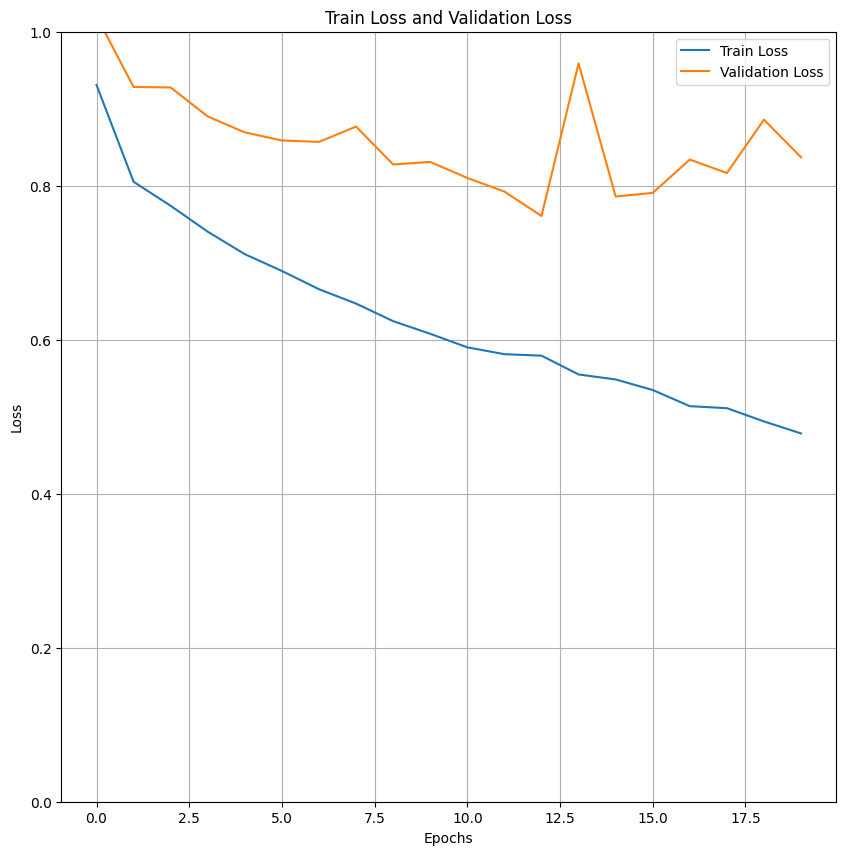

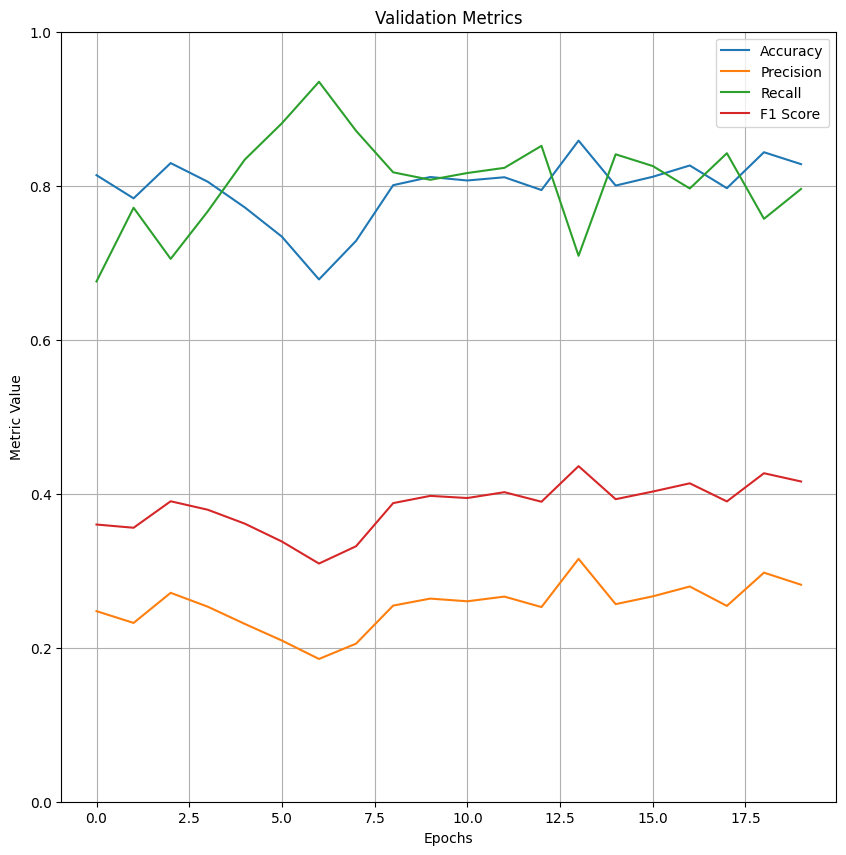

In [ ]:
def parse_metrics(file_path):
    with open(file_path, "r") as file:
        lines = file.readlines()

    data = {
        "epochs": [],
        "training_loss": [],
        "validation_loss": [],
        "accuracy": [],
        "precision": [],
        "recall": [],
        "f1_score": []
    }

    current_epoch = 0
    for line in lines:
        line = line.strip()
        if line.startswith("Train Loss:"):
            data["epochs"].append(current_epoch)
            data["training_loss"].append(float(line.split(":")[1].strip()))
        elif line.startswith("Validation Loss:"):
            data["validation_loss"].append(float(line.split(":")[1].strip()))
        elif line.startswith("Accuracy:"):
            data["accuracy"].append(float(line.split(":")[1].strip()) / 100)
        elif line.startswith("Precision:"):
            data["precision"].append(float(line.split(":")[1].strip()))
        elif line.startswith("Recall:"):
            data["recall"].append(float(line.split(":")[1].strip()))
        elif line.startswith("F1 Score:"):
            data["f1_score"].append(float(line.split(":")[1].strip()))
            current_epoch += 1

    return data

def visualize_metrics(data, output_dir=None):
    epochs = data["epochs"]

    plt.figure(figsize=(10, 10))
    plt.plot(epochs, data["training_loss"], label="Training Loss")
    plt.plot(epochs, data["validation_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)
    if output_dir:
        plt.savefig(os.path.join(output_dir, "loss_curve.png"))
    else:
        plt.show()

    plt.figure(figsize=(10, 10))
    plt.plot(epochs, data["accuracy"], label="Accuracy")
    plt.plot(epochs, data["precision"], label="Precision")
    plt.plot(epochs, data["recall"], label="Recall")
    plt.plot(epochs, data["f1_score"], label="F1 Score")
    plt.xlabel("Epochs")
    plt.ylabel("Metrics")
    plt.title("Validation Metrics Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)
    if output_dir:
        plt.savefig(os.path.join(output_dir, "metrics_curve.png"))
    else:
        plt.show()

metrics_data = parse_metrics(model_dir + "/output/output.txt")
output_directory = os.path.join(model_dir, "graphs")
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
visualize_metrics(metrics_data, output_dir=output_directory)


Test set

In [ ]:
model1_path = os.path.join(model_dir, "better_models", "model_1", "best_model.pth.tar")
#model2_path = os.path.join(model_dir, "better_models", "model_2", "best_model.pth.tar")
#model3_path = os.path.join(model_dir, "better_models", "model_3", "best_model.pth.tar")

model1 = UNET(in_channels=4, out_channels=1).to(device)
#model2 = UNET(in_channels=4, out_channels=1).to(device)
#model3 = UNET(in_channels=4, out_channels=1).to(device)

load_checkpoint(torch.load(model1_path), model1)
#load_checkpoint(torch.load(model2_path), model2)
#load_checkpoint(torch.load(model3_path), model3)

criterion = nn.BCEWithLogitsLoss()


=> Loading checkpoint


In [ ]:
test_transform = A.Compose([
    A.Resize(height=512, width=512),
    ToTensorV2(),
])

test_dataset = SN7Dataset(image_dir_test, mask_dir_test, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=8, pin_memory=True)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
Validation Loss: 0.2552
Accuracy: 86.93
Precision: 0.2635
Recall: 0.7787
F1 Score: 0.3932


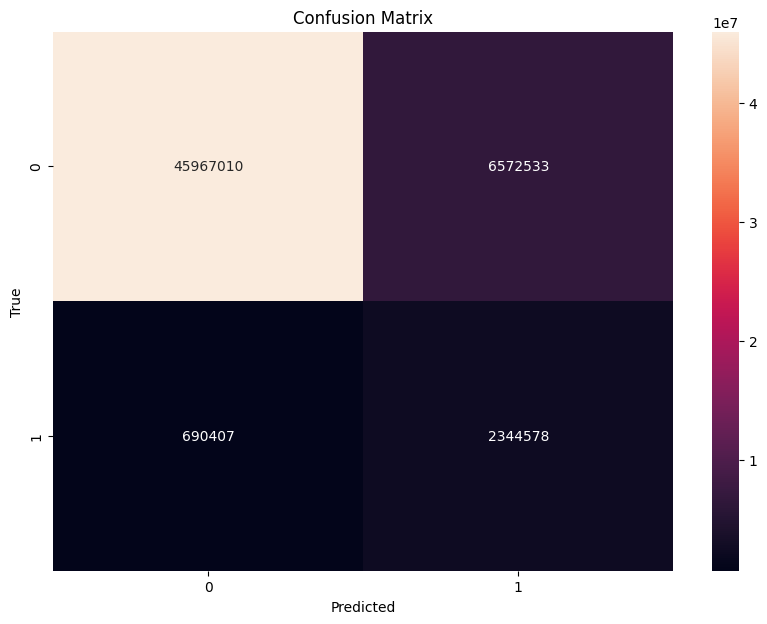

In [ ]:
test_loss1, test_accuracy1, test_precision1, test_recall1, test_f1_1 = eval_fn(test_loader, model1, criterion, os.path.join(output_dir, "output_test"), device=device, testing=True)